In [5]:
import pandas as pd 
import numpy as np

from functools import reduce

from selectpairs import build_pair_universe
from backtest import backtest_pair
from buyandhold import buyhold_benchmark_neutral
from metrics import compute_pair_metrics
from plotpairs import plot_strategy_vs_benchmark
from loaddata import load_model_predictions_with_tag



In [6]:
close = pd.read_csv('../data/close_prices.csv')

folders = [
    "../LSTM/outputs",
    "../XLSTM/output_xlstm",
    "../GRU/output"
]
model_tags = ["LSTM", "XLSTM", "GRU"]


model_tables = []
for folder_path, tag in zip(folders, model_tags):
    tbl = load_model_predictions_with_tag(folder_path, tag)
    if tbl is not None:
        model_tables.append(tbl)

if not model_tables:
    raise RuntimeError("No predictions loaded, check folder paths and files.")

ensemble = reduce(
    lambda left, right: pd.merge(left, right, on="Date", how="outer"),
    model_tables
)


stocks = sorted({c.split("_")[0] for c in ensemble.columns if c != "Date"})

mean_predicted = pd.DataFrame({"Date": ensemble["Date"]})

for stock in stocks:
    cols = [c for c in ensemble.columns if c.startswith(stock + "_")]
    if cols:
        mean_predicted[stock] = ensemble[cols].mean(axis=1)



spy = close[['Date', 'SPY']]
close = close.drop(columns=['SPY', 'QQQ'])
mean_predicted = mean_predicted.drop(columns=['SPY', 'QQQ'])

display(mean_predicted.head())




[OK] Loaded 10 stock files from ../LSTM/outputs (LSTM)
[OK] Loaded 10 stock files from ../XLSTM/output_xlstm (XLSTM)
[OK] Loaded 12 stock files from ../GRU/output (GRU)


,Date,AAPL,AMZN,AVGO,GOOGL,META,MSFT,NFLX,NVDA,ORCL,TSLA
0,2023-01-03,123.333973,85.993820,52.986112,88.640062,123.826061,234.591250,295.489203,14.307467,80.733272,108.647452
1,2023-01-04,124.117308,85.460722,53.311077,88.015081,125.892767,228.051169,306.053326,14.670215,81.206804,112.111268
2,2023-01-05,123.096793,84.056299,52.885294,86.837713,125.943193,223.926816,307.104464,14.422008,81.037573,109.479259
3,2023-01-06,126.037513,85.938007,54.963788,87.638433,128.433026,225.730437,312.060530,14.887195,81.684431,111.147134
4,2023-01-09,126.259811,86.785406,54.162796,88.081333,128.385097,227.075514,312.712853,15.440967,82.524978,115.300314


In [7]:
pair_df = build_pair_universe(
    close_df=close,
    train_end="2023-01-01",
    corr_threshold=0.6,
    min_len=50,
    pval_threshold=0.05,
    top_n=30
)

pair_df.head(15)


,stock1,stock2,pvalue,alpha,beta,mu,sigma,n_obs
0,GOOGL,ORCL,0.013004,-2.864890,1.785789,-2.864890,0.176204,3272
1,AAPL,ORCL,0.013883,-4.651317,2.231606,-4.651317,0.235064,3272
2,AAPL,MSFT,0.023189,-0.526110,0.970733,-0.526110,0.193965,3272
3,MSFT,ORCL,0.034207,-4.012481,2.233728,-4.012481,0.253138,3272
4,META,NFLX,0.036199,1.592020,0.639612,1.592020,0.209166,2673


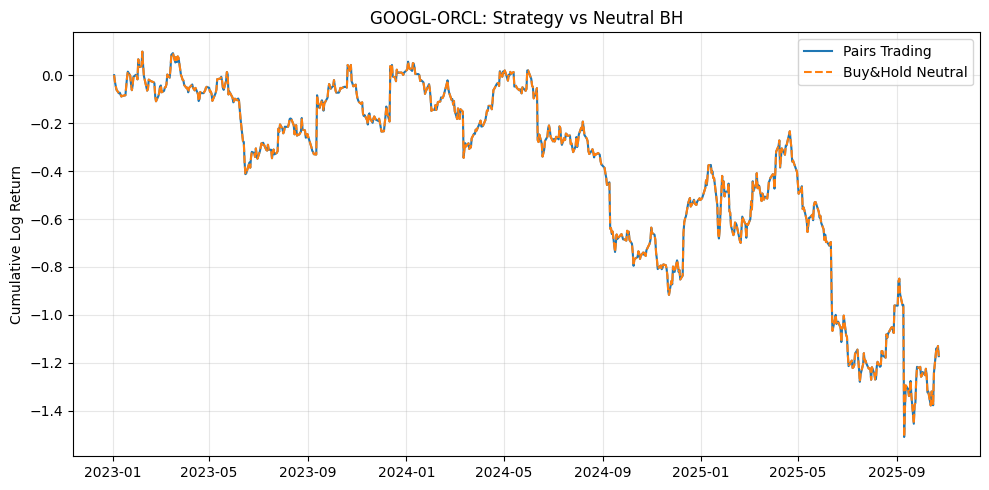

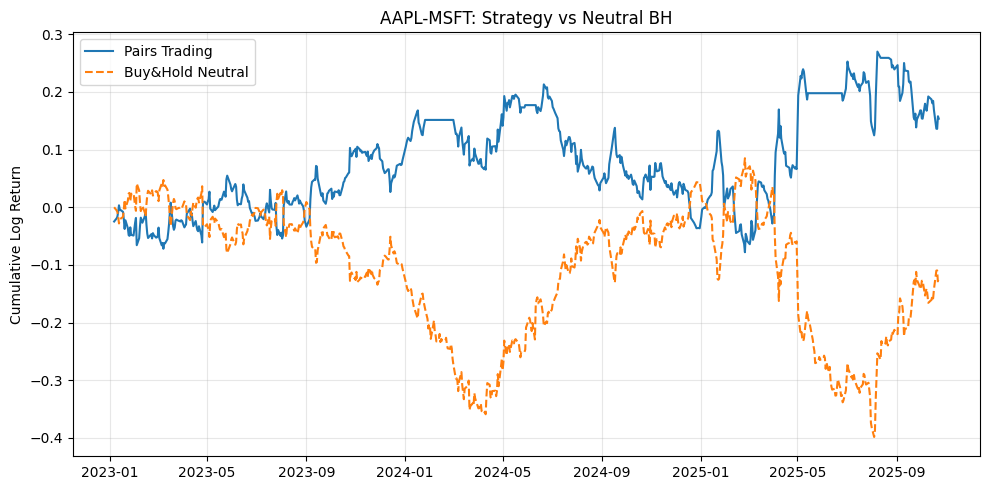

== Strategy vs Neutral Buy&Hold (aligned)==


,Strat_CumRet,Strat_AnnRet,Strat_AnnVol,Strat_Sharpe,Strat_MaxDD,Strat_WinRt,BH_CumRet,BH_AnnRet,BH_AnnVol,BH_Sharpe,BH_MaxDD,BH_WinRt,Days
Pair,,,,,,,,,,,,,
GOOGL-ORCL,-0.6903,-0.3423,0.7186,-0.5831,-0.7997,0.4865,-0.6903,-0.3423,0.7186,-0.5831,-0.7997,0.4865,705
AAPL-MSFT,0.1660,0.0567,0.2312,0.2384,-0.2526,0.4359,-0.1195,-0.0446,0.2425,-0.1883,-0.3835,0.5043,702


== Excess (Strategy - BH-Neutral) ==


,Excess_AnnRet,Excess_Sharpe,Excess_CumRet
Pair,,,
GOOGL-ORCL,0.0000,0.0000,0.0000
AAPL-MSFT,0.1013,0.4268,0.2854


In [8]:
pairs_to_use = [
    ("GOOGL", "ORCL"),
    ("AAPL", "MSFT"),
]

results = {}
benchmarks = {}
metrics_rows = []          
excess_rows = []         

for s1, s2 in pairs_to_use:
    match = pair_df[(pair_df["stock1"] == s1) & (pair_df["stock2"] == s2)]
    if match.empty:
        print(f"Pair ({s1}, {s2}) not found in pair_df, skipped.")
        continue

    row = match.iloc[0]
    key = (s1, s2)
    
    res = backtest_pair(mean_predicted, close, row)
    results[key] = res
    # plot_pair_performance(res, row)

    first_trade_date = res.loc[(res["pos_" + s1] != 0) | (res["pos_" + s2] != 0)].index[0]
    close["Date"] = pd.to_datetime(close["Date"])
    actual_window = close.loc[close["Date"] >= first_trade_date, ["Date", s1, s2]]


    bh = buyhold_benchmark_neutral(actual_window, row)
    idx = res.index.intersection(bh.index)
    bh_aligned = bh.loc[idx].copy()
    res_aligned = res.loc[idx].copy()
    benchmarks[key] = bh_aligned
    
    plot_strategy_vs_benchmark(res_aligned, bh_aligned, title=f"{s1}-{s2}: Strategy vs Neutral BH")

    #compute_pair_metrics
    m_strat = compute_pair_metrics(res_aligned)
    m_bh    = compute_pair_metrics(bh_aligned)

    metrics_rows.append({
        "Pair": f"{s1}-{s2}",
        # strategy
        "Strat_CumRet": m_strat["CumulativeReturn"],
        "Strat_AnnRet": m_strat["AnnualizedReturn"],
        "Strat_AnnVol": m_strat["AnnualVolatility"],
        "Strat_Sharpe": m_strat["SharpeRatio"],
        "Strat_MaxDD" : m_strat["MaxDrawdown"],
        "Strat_WinRt" : m_strat["WinRate"],
        # benchmark
        "BH_CumRet": m_bh["CumulativeReturn"],
        "BH_AnnRet": m_bh["AnnualizedReturn"],
        "BH_AnnVol": m_bh["AnnualVolatility"],
        "BH_Sharpe": m_bh["SharpeRatio"],
        "BH_MaxDD" : m_bh["MaxDrawdown"],
        "BH_WinRt" : m_bh["WinRate"],
        "Days": m_strat["Days"]
    })

    excess_rows.append({
        "Pair": f"{s1}-{s2}",
        "Excess_AnnRet": (m_strat["AnnualizedReturn"] - m_bh["AnnualizedReturn"]),
        "Excess_Sharpe": (m_strat["SharpeRatio"] - m_bh["SharpeRatio"]),
        "Excess_CumRet": (m_strat["CumulativeReturn"] - m_bh["CumulativeReturn"]),
    })

df_metrics = pd.DataFrame(metrics_rows).set_index("Pair")
df_excess  = pd.DataFrame(excess_rows).set_index("Pair")


print("== Strategy vs Neutral Buy&Hold (aligned)==")
display(df_metrics.round(4))

print("== Excess (Strategy - BH-Neutral) ==")
display(df_excess.round(4))